In [ ]:
print(len(imp_wts))

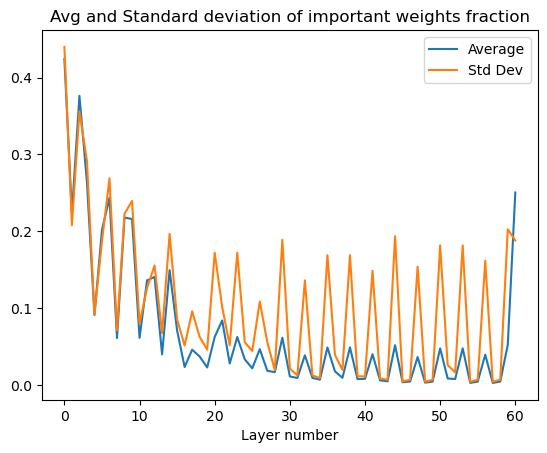

0.0%

100.0%


Extracting data/CIFAR10/cifar-10-python.tar.gz to data/CIFAR10
Files already downloaded and verified
[37, 205, 27, 51, 0, 0, 0, 0, 0, 0] 320
[63, 145, 59, 53, 0, 0, 0, 0, 0, 0] 320
[47, 175, 56, 42, 0, 0, 0, 0, 0, 0] 320
[33, 197, 32, 58, 0, 0, 0, 0, 0, 0] 320
[27, 266, 18, 9, 0, 0, 0, 0, 0, 0] 320
[14, 263, 26, 17, 0, 0, 0, 0, 0, 0] 320
[12, 294, 8, 6, 0, 0, 0, 0, 0, 0] 320
[3, 303, 9, 5, 0, 0, 0, 0, 0, 0] 320
[40, 176, 55, 49, 0, 0, 0, 0, 0, 0] 320
[48, 144, 59, 69, 0, 0, 0, 0, 0, 0] 320
[50, 193, 28, 49, 0, 0, 0, 0, 0, 0] 320
[46, 211, 39, 24, 0, 0, 0, 0, 0, 0] 320
[30, 248, 19, 23, 0, 0, 0, 0, 0, 0] 320
[17, 262, 28, 13, 0, 0, 0, 0, 0, 0] 320
[3, 299, 11, 7, 0, 0, 0, 0, 0, 0] 320
[4, 304, 6, 6, 0, 0, 0, 0, 0, 0] 320
[33, 207, 39, 41, 0, 0, 0, 0, 0, 0] 320
[49, 162, 55, 54, 0, 0, 0, 0, 0, 0] 320
[51, 173, 48, 48, 0, 0, 0, 0, 0, 0] 320
[46, 172, 50, 52, 0, 0, 0, 0, 0, 0] 320
[25, 248, 15, 32, 0, 0, 0, 0, 0, 0] 320
[15, 277, 13, 15, 0, 0, 0, 0, 0, 0] 320
[6, 299, 14, 1, 0, 0, 0, 0, 0,

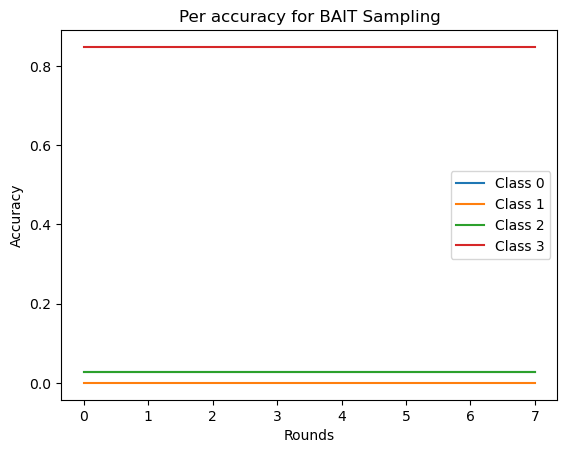

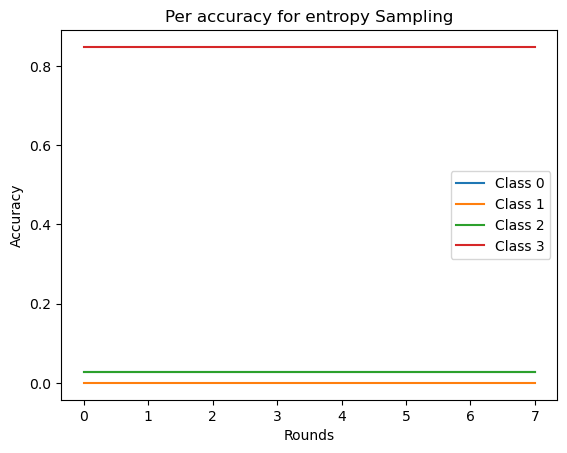

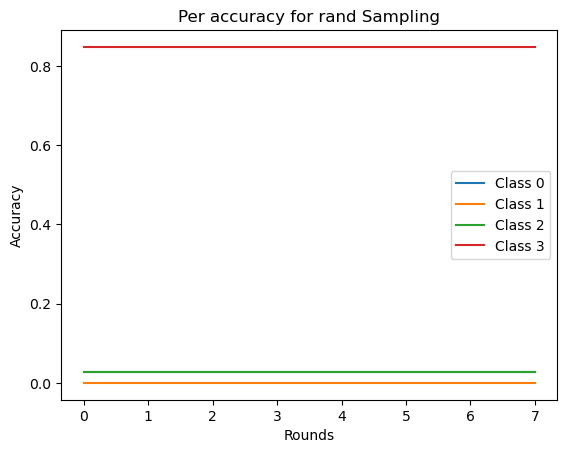

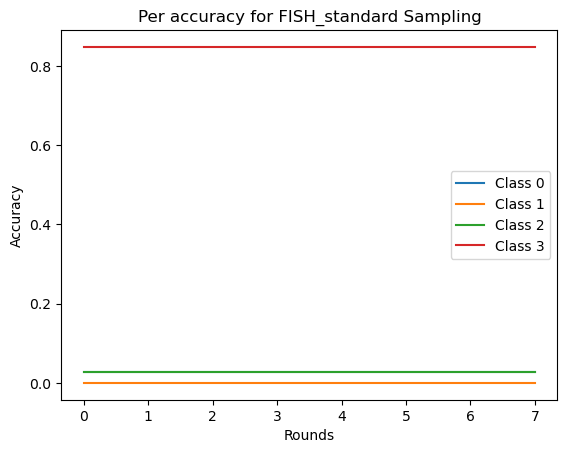

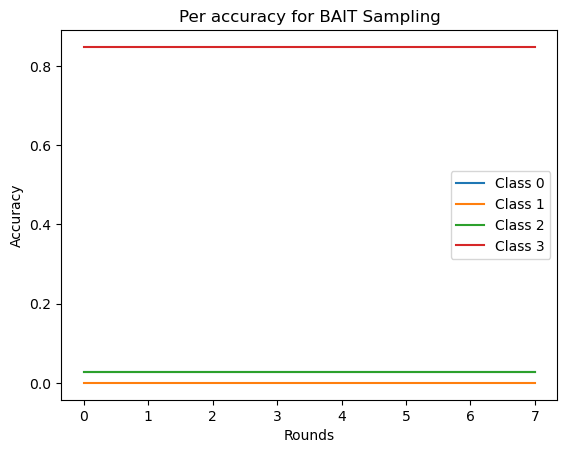

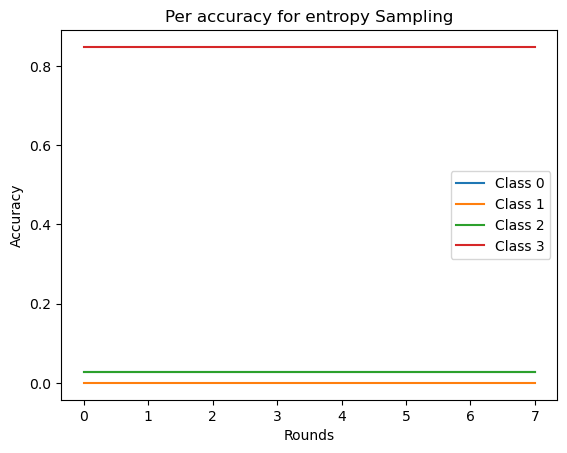

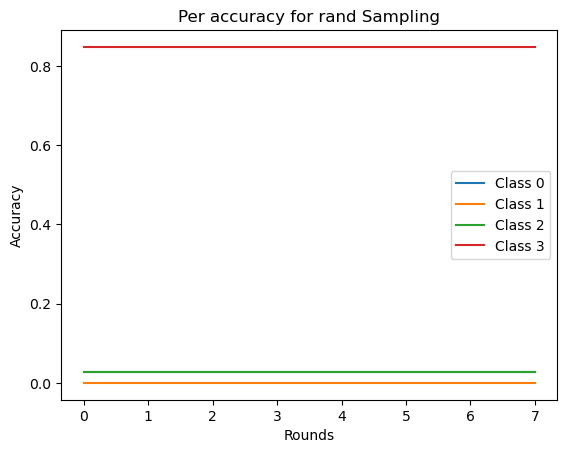

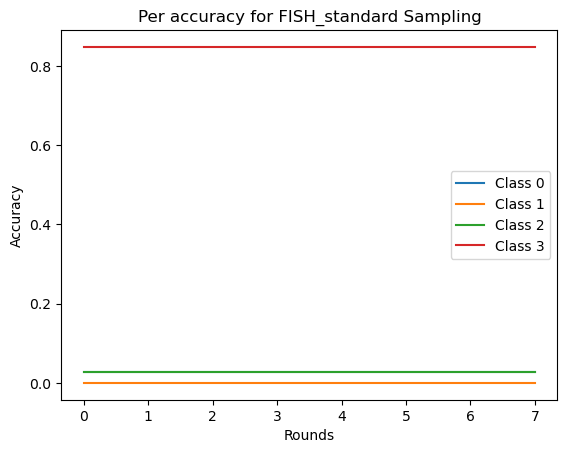

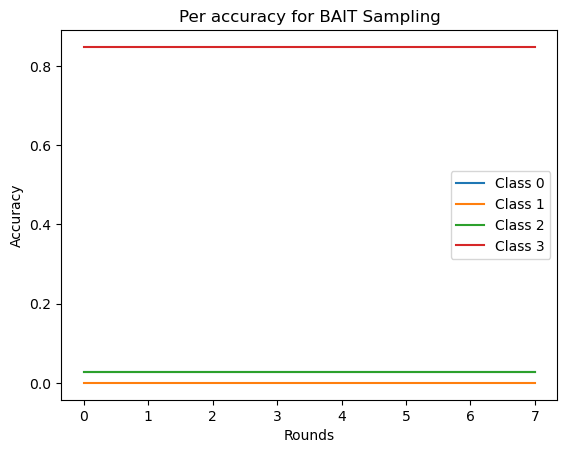

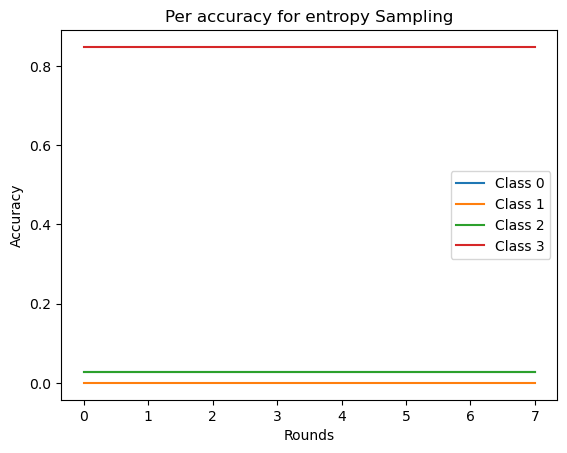

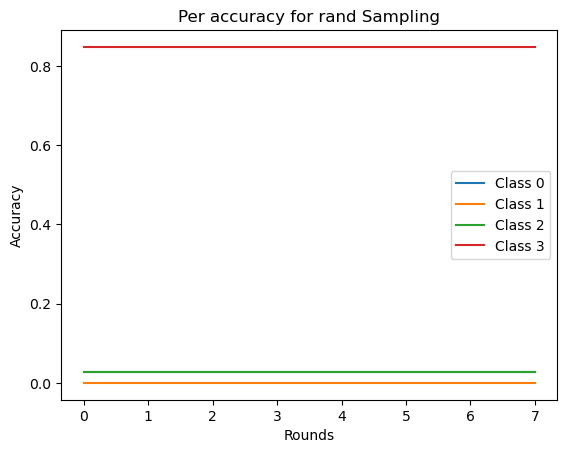

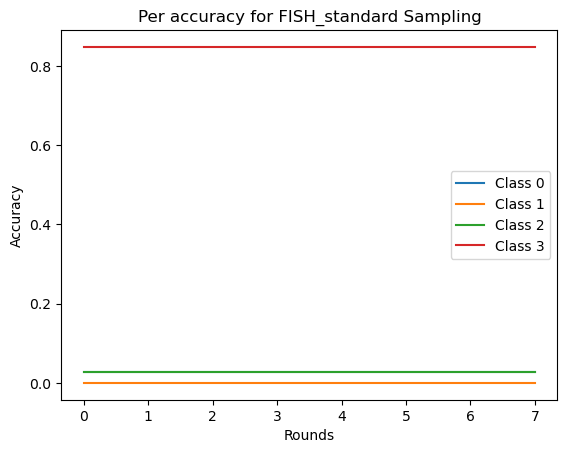

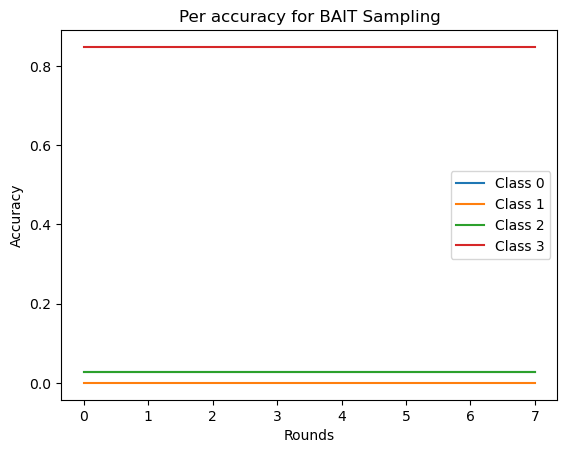

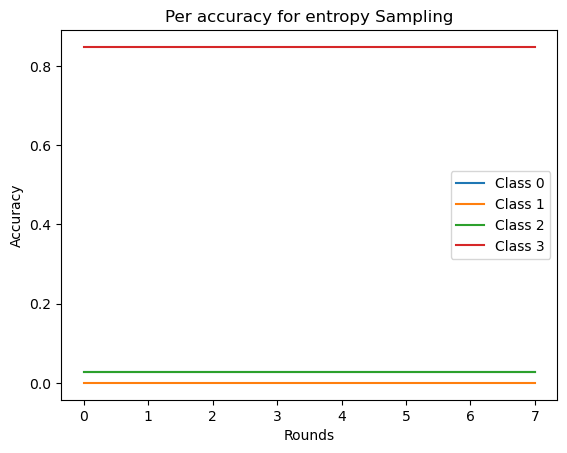

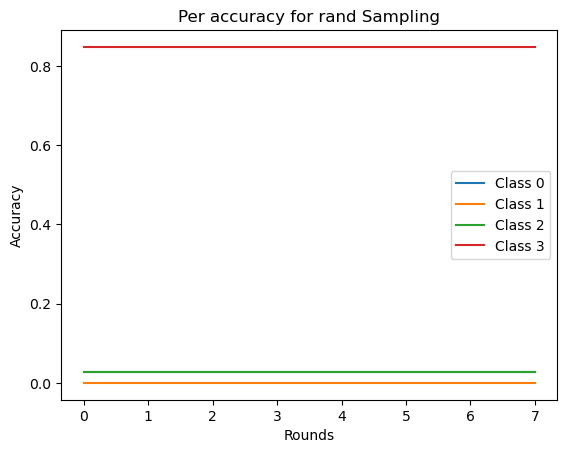

KeyboardInterrupt: 

In [2]:
import pickle
import numpy as np
import torch
import resnet
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from dataset import get_dataset, get_handler
from saving import load_model

#load important weights
savefile = "fish_arch_test"
imp_wts = pickle.load(open("../Save/Imp_weights/imp_wts_idxs_" + savefile + ".p", "rb"))

#create layer-by-layer important weights fraction graph average and standard deviation
model = resnet.ResNet18()
frac_imp = {l: [] for l in range(len(imp_wts[0]))}
for layer_num, param in enumerate(model.parameters()):
    frac_imp[layer_num] = [len(imp_wts[rd][layer_num]) / np.prod(param.shape) for rd in range(len(imp_wts))]
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
plt.plot([np.std(frac_imp[l]) for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
plt.savefig("impwtsperlayerstats.png", format="png", dpi=5000)
plt.show()

#check class composition
def unbalanced_test_dataset(X_tr, Y_tr):

    masks = [np.zeros(len(Y_tr), dtype = 'int') for i in range(10)]
    for i in range(len(Y_tr)):
        masks[Y_tr[i].item()][i] = 1

    var = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[0] == 1], 1000, replace=False)
    var2 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[1] == 1], 1000, replace=False)
    var3 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[2] == 1], 1000, replace=False)
    var4 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[3] == 1], 1000, replace=False)
    
    new_Xtr = np.concatenate((X_tr[var], X_tr[var2], X_tr[var3], X_tr[var4]))
    new_Ytr = np.zeros(len(new_Xtr), dtype = 'int')
    new_Ytr[0:1000] = 0
    new_Ytr[1000: 2000] = 1
    
    new_Ytr[2000: 3000] = 2
    new_Ytr[3000 : 4000] = 3
    return new_Xtr, torch.from_numpy(new_Ytr)

dataset = pickle.load(open("../Save/Queried_idxs/" + "dataset_" + savefile + ".p", "rb"))
X_tr, Y_tr, X_te, Y_te = get_dataset('CIFAR10', 'data')
X_tr = dataset['X_train']
Y_tr = dataset['Y_train']
X_te, Y_te = unbalanced_test_dataset(X_te, Y_te)
BAIT_qd_idxs = pickle.load(open("../Save/Queried_idxs/" + "BAIT_queried_idxs_" + savefile + ".p", "rb"))
BAIT_class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in BAIT_qd_idxs]
BAIT_class_comp = []
print("BAIT class composition:")
for rd in range(len(BAIT_class_composition)):
    class_rd = [sum(np.array(BAIT_class_composition[rd]) == cl) for cl in range(10)]
    BAIT_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

Entropy_qd_idxs = pickle.load(open("../Save/Queried_idxs/" + "entropy_queried_idxs_" + savefile + ".p", "rb"))
Entropy_class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in Entropy_qd_idxs]
Entropy_class_comp = []
print("Entropy class composition:")
for rd in range(len(Entropy_class_composition)):
    class_rd = [sum(np.array(Entropy_class_composition[rd]) == cl) for cl in range(10)]
    Entropy_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

RAND_qd_idxs = pickle.load(open("../Save/Queried_idxs/" + "rand_queried_idxs_" + savefile + ".p", "rb"))
RAND_class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in RAND_qd_idxs]
RAND_class_comp = []
print("rand class composition:")
for rd in range(len(RAND_class_composition)):
    class_rd = [sum(np.array(RAND_class_composition[rd]) == cl) for cl in range(10)]
    RAND_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

FISH_qd_idxs = pickle.load(open("../Save/Queried_idxs/" + "FISH_queried_idxs_" + savefile + ".p", "rb"))
FISH_class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in FISH_qd_idxs]
FISH_class_comp = []
print("FISH class composition:")
for rd in range(len(FISH_class_composition)):
    class_rd = [sum(np.array(FISH_class_composition[rd]) == cl) for cl in range(10)]
    FISH_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))



#Per-class test accuracy of model
net = resnet.ResNet18(num_classes=4)
def predict(net,X, Y):
    if type(X) is np.ndarray:
        loader_te = DataLoader(handler(X, Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])
    else: 
        loader_te = DataLoader(handler(X.numpy(), Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])

    net.eval()
    P = torch.zeros(len(Y)).long()
    with torch.no_grad():
        for x, y, idxs in loader_te:
            x, y = Variable(x), Variable(y)
            out, e1 = net(x)
            pred = out.max(1)[1]
            P[idxs] = pred.data.cpu()
    return P

def check_acc(net,X,Y):
    P = predict(net,X, Y)
    accur = 1.0 * (Y == P).sum().item() / len(Y)
    return accur


idxs_lb = 5750
args = {'transform':transforms.Compose([transforms.ToTensor()]),
                'n_epoch':10,
                'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                'loader_te_args':{'batch_size': 100, 'num_workers': 1},
                'optimizer_args':{'lr': 0.01, 'momentum': 0},
                'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]),
                'fishIdentity' : 0,
                'fishInit': 1,
                'lamb':1,
                'backwardSteps':1,
                'savefile': "Random_vs_BAIT_new",
                'chunkSize': 200}
handler = get_handler('CIFAR10')

masks = [np.zeros(len(Y_te), dtype = 'int') for i in range(10)]
for i in range(len(Y_te)):
    masks[Y_te[i].item()][i] = 1

X_te_0 = X_te[np.arange(len(X_te), dtype=int)[masks[0] == 1]]
X_te_1 = X_te[np.arange(len(X_te), dtype=int)[masks[1] == 1]]
X_te_2 = X_te[np.arange(len(X_te), dtype=int)[masks[2] == 1]]
X_te_3 = X_te[np.arange(len(X_te), dtype=int)[masks[3] == 1]]

Y_te_0 = torch.from_numpy(np.array([0]*1000))
Y_te_1 = torch.from_numpy(np.array([1]*1000))
Y_te_2 = torch.from_numpy(np.array([2]*1000))
Y_te_3 = torch.from_numpy(np.array([3]*1000))


for trial in range(1):
    file = savefile + str(trial)
    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "BAIT")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for BAIT Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "entropy")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for entropy Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "rand")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for rand Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "FISH")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for FISH_standard Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    file = savefile + str(trial) + "_dispersed"
    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "FISH")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for FISH_dispersed Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    file = savefile + str(trial) + "_relative"
    class_0 ,class_1 , class_2 , class_3 = [], [], [], []
    for i in range(0,8):
        load_model(i, net, file, "FISH")
        class_0.append(check_acc(net,X_te_0, Y_te_0))
        class_1.append(check_acc(net,X_te_1, Y_te_1))
        class_2.append(check_acc(net,X_te_2, Y_te_2))
        class_3.append(check_acc(net,X_te_3, Y_te_3))
    plt.plot(class_0, label='Class 0')
    plt.plot(class_1, label="Class 1")
    plt.plot(class_2, label="Class 2")
    plt.plot(class_3, label="Class 3")
    plt.title(f'Per class accuracy for FISH_relative Sampling Trial {trial}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()